In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"

sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from DLS.postprocess import *
from code_comparison.solps_pp import *
from AnalyticCoolingCurves import LfuncKallenbachAr

from DLScommonTools import *
from Morph import *
from Postprocess import *
from copy import deepcopy

%matplotlib inline
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2


# Make parametric cooling curve

## Gaussian
- This one doesn't work well because it goes to 0 way before the target
- This creates a region with no radiation between the radiation peak and the target leading to unphysical results

In [2]:
T = np.linspace(0, 500, 1000)

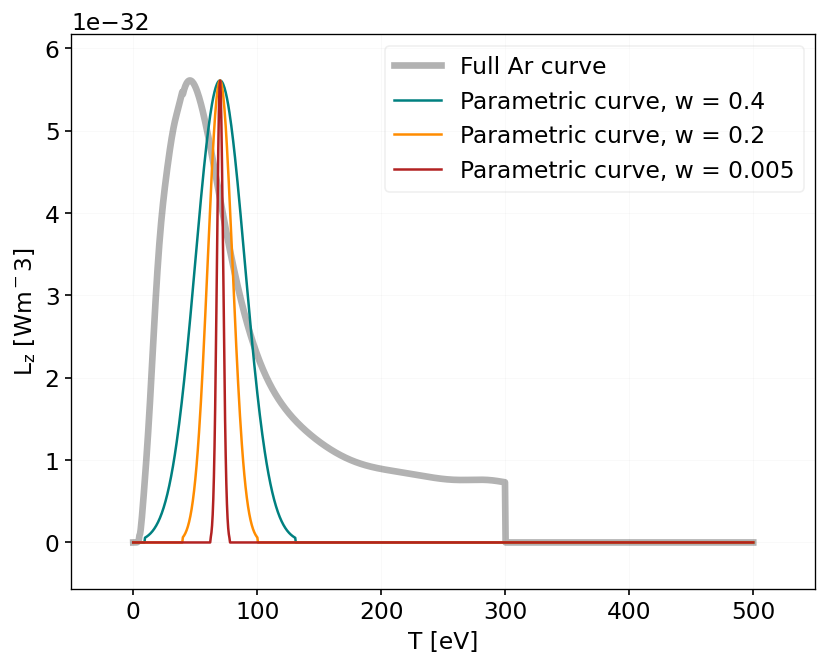

In [3]:


Q = [LfuncKallenbachNe(x) for x in T]


a = 50
T0 = 100
# Q2 = np.sqrt(2/np.pi) * (T)**2 / a**3 * np.exp(-(T)**2 / (2*a**2)) 

def LfuncArParametricGauss(T, w):
    """
    Analytical approximation of the Ar cooling curve
    Made from two gaussians, one for the cold and one for hot end
    w is the width parameter. Value of 1 roughly approximates the original curve.
    Lower values make it much thinner.
    T must be float
    """
    
    # Maximum from actual Ar curve
    max = 5.607318215187935e-32

    # Width parameter (cold and hot end)
    # Was 15/70
    sigmaC = 50*w  
    sigmaH = 50*w
    
    # Distribution centre in T
    mu = 70

    if T < mu:
        Lz = np.exp(-0.5 * ((T - mu)/(sigmaC))**2) * max
    elif T >= mu:
        Lz = np.exp(-0.5 * ((T - mu)/(sigmaH))**2) * max 
    elif T >= 300:
        Lz = 0
        
    if Lz < max * 0.01:
        Lz = 0
    
    return Lz

fig, ax = plt.subplots()

ax.plot(T, Q, lw = 4, alpha = 0.3, c = "k", label = r"Full Ar curve")
ax.plot(T, [LfuncArParametricGauss(x, 0.4) for x in T], lw = 1.5, label = "Parametric curve, w = 0.4")
ax.plot(T, [LfuncArParametricGauss(x, 0.2) for x in T], lw = 1.5, label = "Parametric curve, w = 0.2")
ax.plot(T, [LfuncArParametricGauss(x, 0.05) for x in T], lw = 1.5, label = "Parametric curve, w = 0.005")
ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
ax.legend()
# ax.set_xlim(10,60)

## Triangular, no shoulder
- This one gives physical results
- Front narrows as it nears the X-point

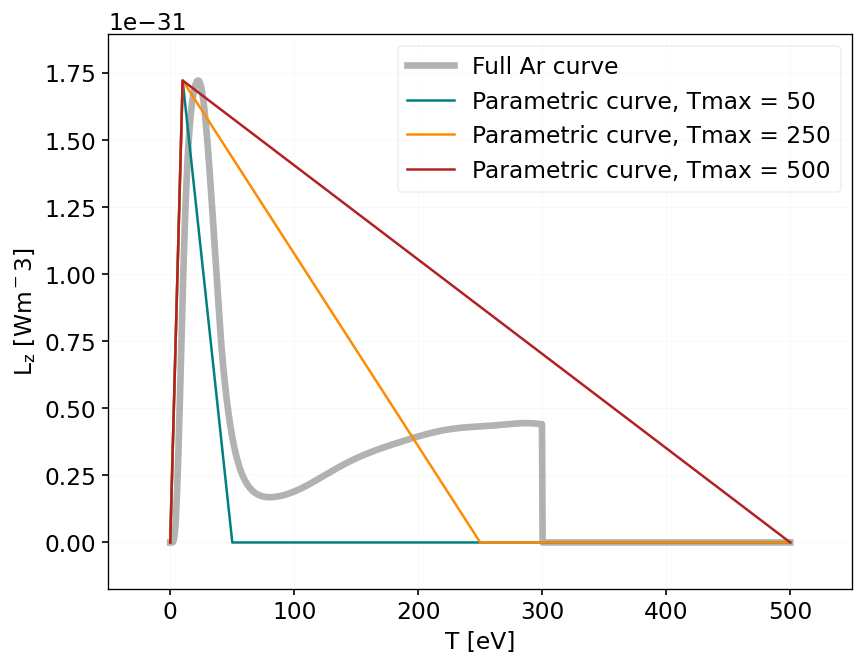

In [4]:
def LfuncArParametricTri(T, Tmax = 60):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    max_pos = 10
    
    x0 = 0
    y0 = 0
    x1 = max_pos
    y1 = max
    x2 = Tmax
    y2 = 0
    
    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = 0

    
    return Lz

fig, ax = plt.subplots()

ax.plot(T, [LfuncKallenbachAr(x) for x in T], lw = 4, alpha = 0.3, c = "k", label = r"Full Ar curve")
ax.plot(T, [LfuncArParametricTri(x, 50) for x in T], lw = 1.5, label = "Parametric curve, Tmax = 50")
ax.plot(T, [LfuncArParametricTri(x, 250) for x in T], lw = 1.5, label = "Parametric curve, Tmax = 250")
ax.plot(T, [LfuncArParametricTri(x, 500) for x in T], lw = 1.5, label = "Parametric curve, Tmax = 500")
ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
ax.legend()
# ax.set_xlim(10,60)

## Shoulder

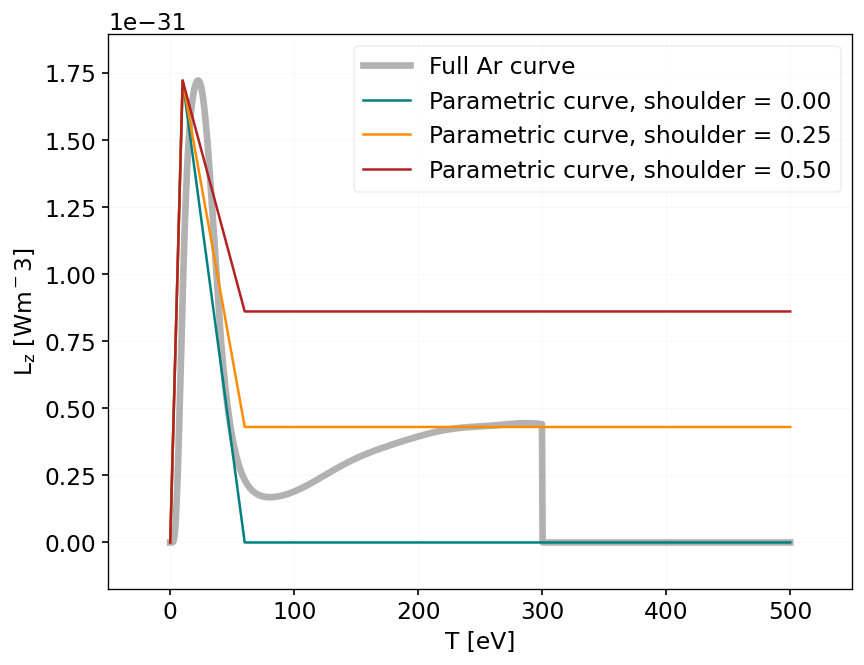

In [5]:
def LfuncArParametricTriShoulder(T, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    max_pos = 10
    
    x0 = 0
    y0 = 0
    x1 = max_pos
    y1 = max
    x2 = 60
    y2 = max * height
    
    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

fig, ax = plt.subplots()

ax.plot(T, [LfuncKallenbachAr(x) for x in T], lw = 4, alpha = 0.3, c = "k", label = r"Full Ar curve")
ax.plot(T, [LfuncArParametricTriShoulder(x, 0.0) for x in T], lw = 1.5, label = "Parametric curve, shoulder = 0.00")
ax.plot(T, [LfuncArParametricTriShoulder(x, 0.25) for x in T], lw = 1.5, label = "Parametric curve, shoulder = 0.25")
ax.plot(T, [LfuncArParametricTriShoulder(x, 0.5) for x in T], lw = 1.5, label = "Parametric curve, shoulder = 0.50")
ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
ax.legend()
# ax.set_xlim(10,60)

## Shoulder with kink

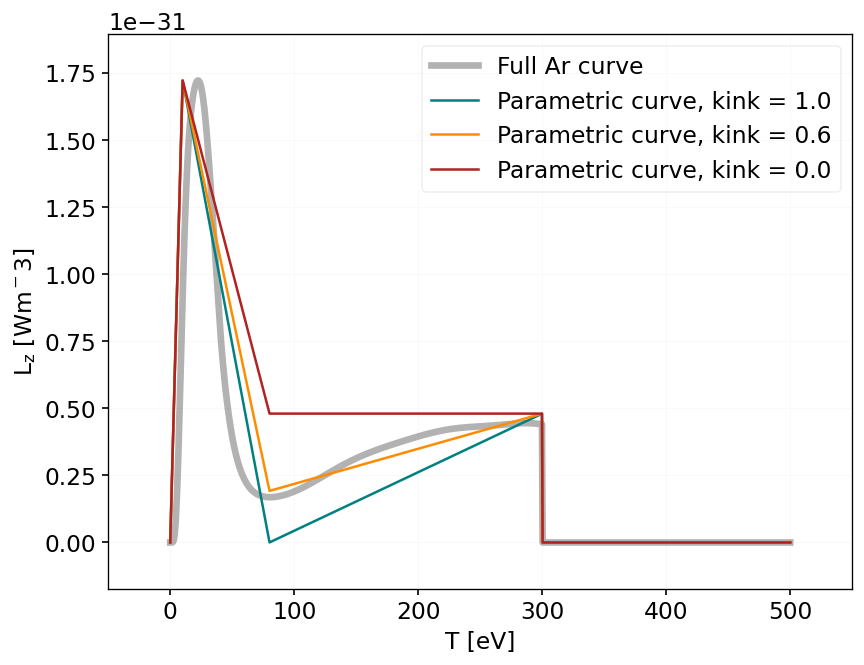

In [6]:
def LfuncArParametricTriShoulderKink(T, kink = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    max_pos = 10
    
    x0 = 0
    y0 = 0
    x1 = max_pos
    y1 = max
    x2 = 80
    y2 = 0.48e-31 * (1-kink)
    x3 = 300
    y3 = 0.48e-31
    
    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    elif T >= x2 and T < x3:
        Lz = (y2 * (x3 - T) + y3 * (T - x2)) / (x3 - x2)
    else:
        Lz = 0

    
    return Lz

fig, ax = plt.subplots()

ax.plot(T, [LfuncKallenbachAr(x) for x in T], lw = 4, alpha = 0.3, c = "k", label = r"Full Ar curve")
ax.plot(T, [LfuncArParametricTriShoulderKink(x, 1) for x in T], lw = 1.5, label = "Parametric curve, kink = 1.0")
ax.plot(T, [LfuncArParametricTriShoulderKink(x, 0.6) for x in T], lw = 1.5, label = "Parametric curve, kink = 0.6")
ax.plot(T, [LfuncArParametricTriShoulderKink(x, 0) for x in T], lw = 1.5, label = "Parametric curve, kink = 0.0")
ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
ax.legend()
# ax.set_xlim(10,60)

## N, Ne, Ar

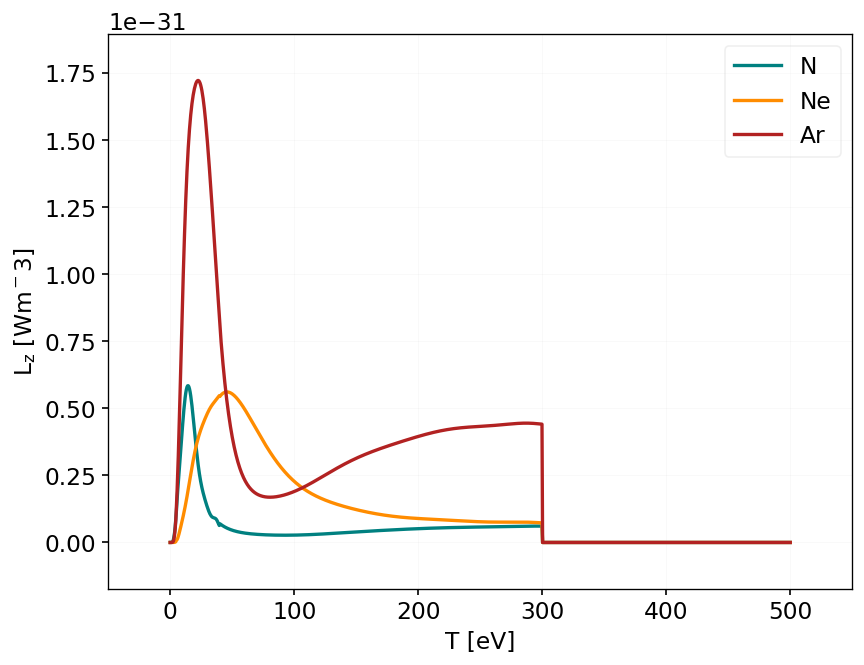

In [7]:
fig, ax = plt.subplots()

ax.plot(T, [LfuncKallenbachN(x) for x in T], lw = 2,  label = r"N")
ax.plot(T, [LfuncKallenbachNe(x) for x in T], lw = 2, label = "Ne")
ax.plot(T, [LfuncKallenbachAr(x) for x in T], lw = 2, label = "Ar")
ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
ax.legend()

## Peak location

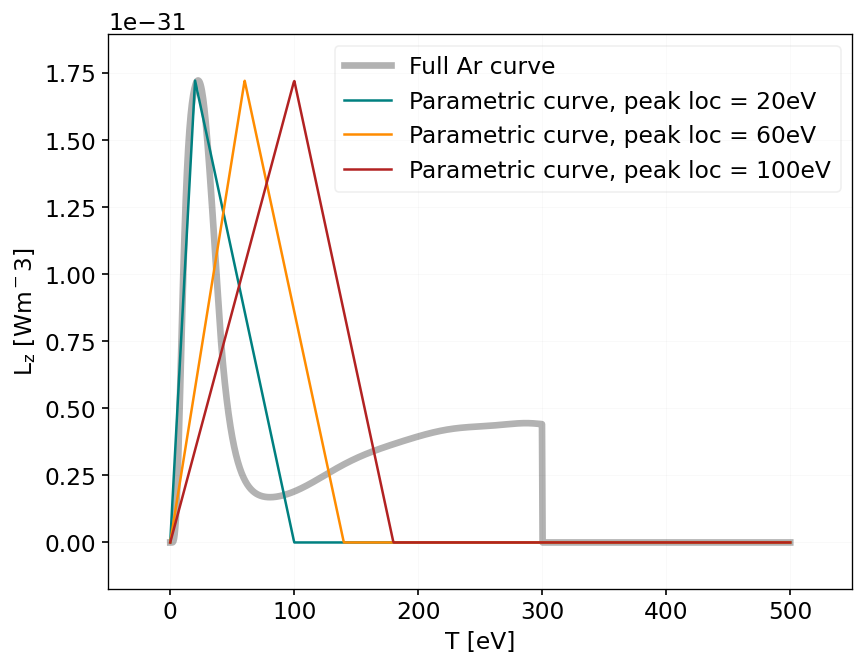

In [8]:

def LfuncArParametricTriPeakLoc(T, max_pos = 20):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    x1 = max_pos
    y1 = max
    x2 = 80 + max_pos
    y2 = 0
    
    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = 0

    
    return Lz

fig, ax = plt.subplots()

ax.plot(T, [LfuncKallenbachAr(x) for x in T], lw = 4, alpha = 0.3, c = "k", label = r"Full Ar curve")
ax.plot(T, [LfuncArParametricTriPeakLoc(x, 20) for x in T], lw = 1.5, label = "Parametric curve, peak loc = 20eV")
ax.plot(T, [LfuncArParametricTriPeakLoc(x, 60) for x in T], lw = 1.5, label = "Parametric curve, peak loc = 60eV")
ax.plot(T, [LfuncArParametricTriPeakLoc(x, 100) for x in T], lw = 1.5, label = "Parametric curve, peak loc = 100eV")
ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
ax.legend()
# ax.set_xlim(10,60)

# Read balance file

In [183]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for res in [10000, 100000]:
    eqb["SPR45"][res] = dict()
    
    for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
        eqb["SPR45"][res][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = res)
        
        keys = list(eqb["SPR45"][res][side].keys())
        for key in keys:
            
            if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
                eqb["SPR45"][res][side].pop(key, None)
        
file_write(eqb, "equilibrium_100k.pkl")

In [10]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

# Setup and run DLS

In [11]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

# Run

## No shoulder

In [12]:
cvar = "density"
design = "SPR45"
side = "ol"

store_noshoulder = dict()

for Tmax in [50,250,500]:
# for w_factor in [0.005]:
    d = eqb["SPR45"][side].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 5) # Don't solve up to xpoint cause it won't like it with narrow curves

    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
        
    def Lfunc(T):
        return LfuncArParametricTri(T, Tmax)
        
    constants["Lfunc"] = Lfunc

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)

    store_noshoulder[Tmax] = copy.deepcopy(results)
    

Solving...0...2475...3416...3684...3769...Complete in 27.6 seconds
Solving...0...2475...3416...3684...3769...Complete in 30.8 seconds
Solving...0...2475...3416...3684...3769...Complete in 29.0 seconds


## Shoulder

In [13]:
cvar = "density"
design = "SPR45"
side = "ol"

store_shoulder = dict()

for shoulder in [0.00, 0.25, 0.50]:
# for w_factor in [0.005]:
    d = eqb["SPR45"][side].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 5) # Don't solve up to xpoint cause it won't like it with narrow curves

    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
        
    def Lfunc(T):
        return LfuncArParametricTriShoulder(T, shoulder)
        
    constants["Lfunc"] = Lfunc

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)

    store_shoulder[shoulder] = copy.deepcopy(results)
    

Solving...0...2475...3416...3684...3769...Complete in 30.6 seconds
Solving...0...2475...3416...3684...3769...Complete in 36.5 seconds
Solving...0...2475...3416...3684...3769...Complete in 29.8 seconds


## kink

In [184]:
cvar = "density"
design = "SPR45"
side = "ol"

store_kink = dict()

for kink in [1, 0.6, 0]:
# for w_factor in [0.005]:
    d = eqb["SPR45"][100000][side].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 5) # Don't solve up to xpoint cause it won't like it with narrow curves

    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
        
    def Lfunc(T):
        return LfuncArParametricTriShoulderKink(T, kink)
        
    constants["Lfunc"] = Lfunc

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)

    store_kink[kink] = copy.deepcopy(results)
    

Solving...0...24780...34184...36850...37702...Complete in 427.8 seconds
Solving...0...24780...34184...36850...37702...Complete in 427.6 seconds
Solving...0...24780...34184...36850...37702...Complete in 421.0 seconds


## Impurities

In [185]:
cvar = "density"
design = "SPR45"
side = "ol"

store_impurity = dict()

for impurity in ["N", "Ne", "Ar"]:
# for w_factor in [0.005]:
    d = eqb["SPR45"][100000][side].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 5) # Don't solve up to xpoint cause it won't like it with narrow curves

    # SparRange = [d["S"][d["Xpoint"]]]
    ## Unmitigated SPR45 peak power loads + 0.
    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
          
    constants["Lfunc"] = globals()[f"LfuncKallenbach{impurity}"]

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)

    store_impurity[impurity] = copy.deepcopy(results)
    

Solving...0...24780...34184...36850...37702...Complete in 469.1 seconds
Solving...0...24780...34184...36850...37702...Complete in 430.4 seconds
Solving...0...24780...34184...36850...37702...Complete in 454.6 seconds


## Peak location

In [16]:
cvar = "density"
design = "SPR45"
side = "ol"

store_peakloc = dict()

for peak in [20, 60, 100]:
    d = eqb["SPR45"][side].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 5) # Don't solve up to xpoint cause it won't like it with narrow curves

    if "i" in side:
        constants["qpllu0"] = 1.5e9
    elif "o" in side:
        constants["qpllu0"] = 2e9
          
    def Lfunc(T):
        return LfuncArParametricTriPeakLoc(T, peak)
    
    constants["Lfunc"] = Lfunc

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)

    store_peakloc[peak] = copy.deepcopy(results)
    

Solving...0...2475...3416...3684...3769...Complete in 29.3 seconds
Solving...0...2475...3416...3684...3769...Complete in 31.2 seconds
Solving...0...2475...3416...3684...3769...Complete in 28.7 seconds


In [27]:
write_file(store, "2024-03-04 - Parametric cooling curves.pkl")

PicklingError: Can't pickle <function Lfunc at 0x000001C669183A30>: it's not the same object as __main__.Lfunc

In [96]:
%matplotlib inline
plt.close("all")

# Profile histories

## No shoulder

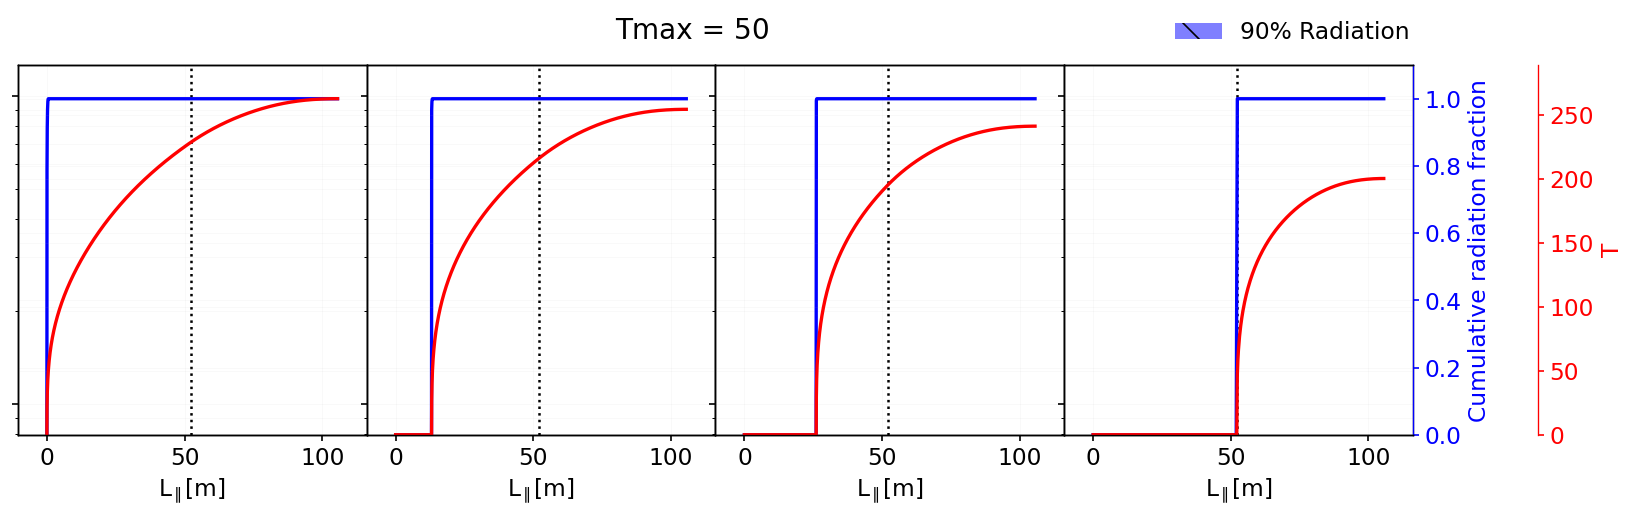

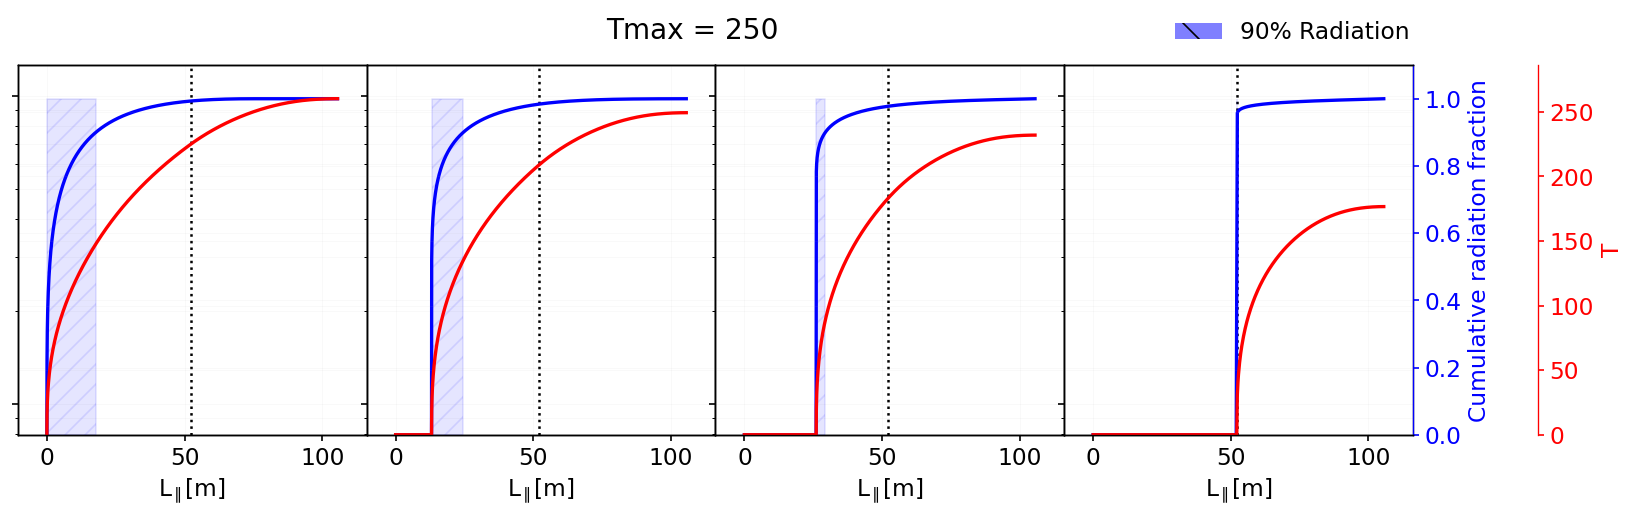

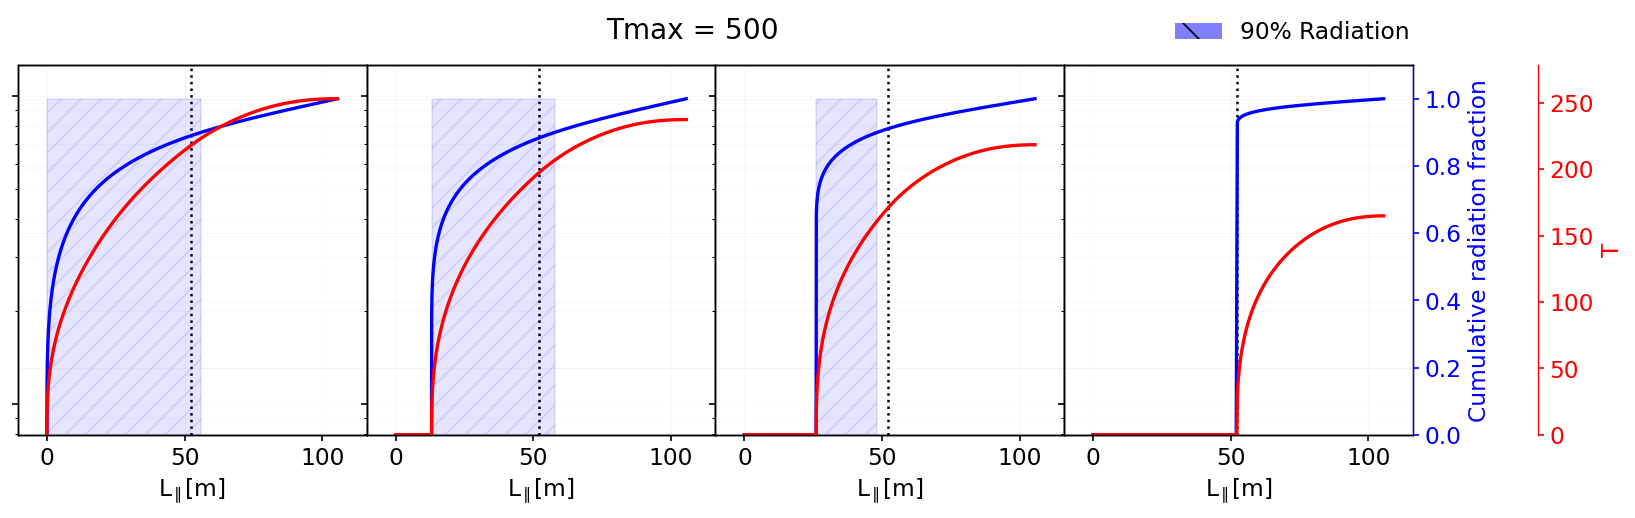

In [242]:
for Tmax in store_noshoulder.keys():
    p = eqb["SPR45"]["ol"]
    s = store_noshoulder[Tmax]
    plot_profile_histories(p, s, [0, 1, 2, 4], rad_threshold = 0.9, mode = "temp", title = f"Tmax = {Tmax}")

## Shoulder

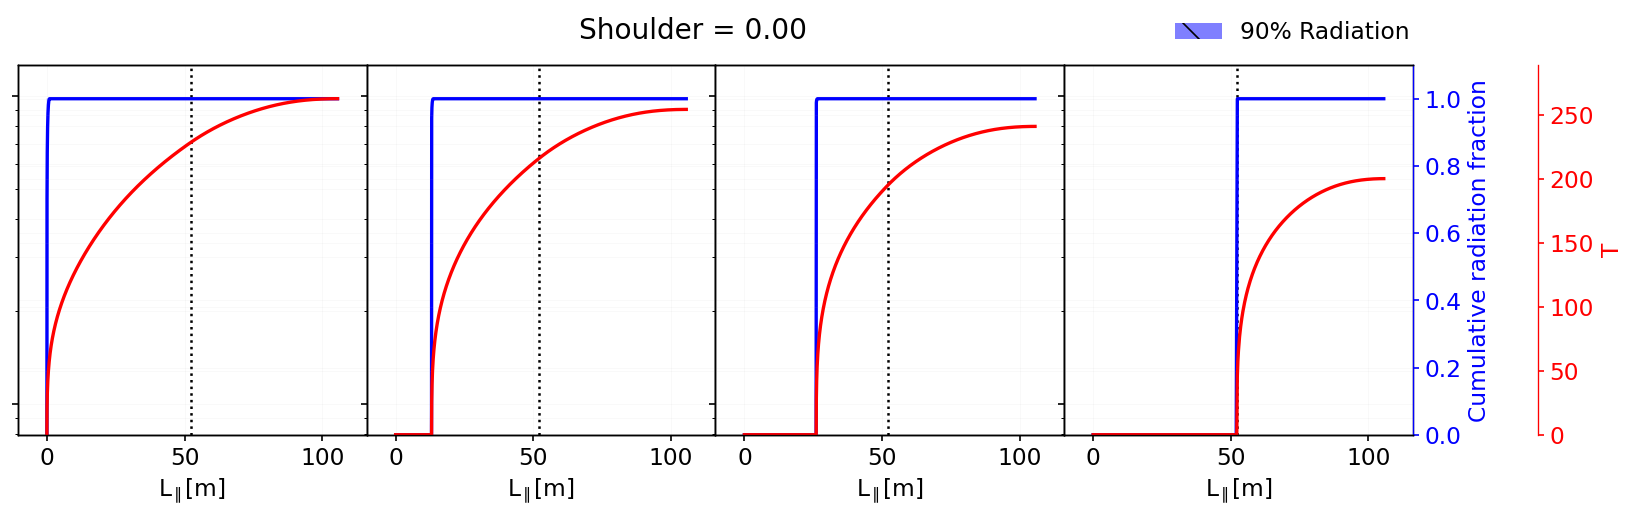

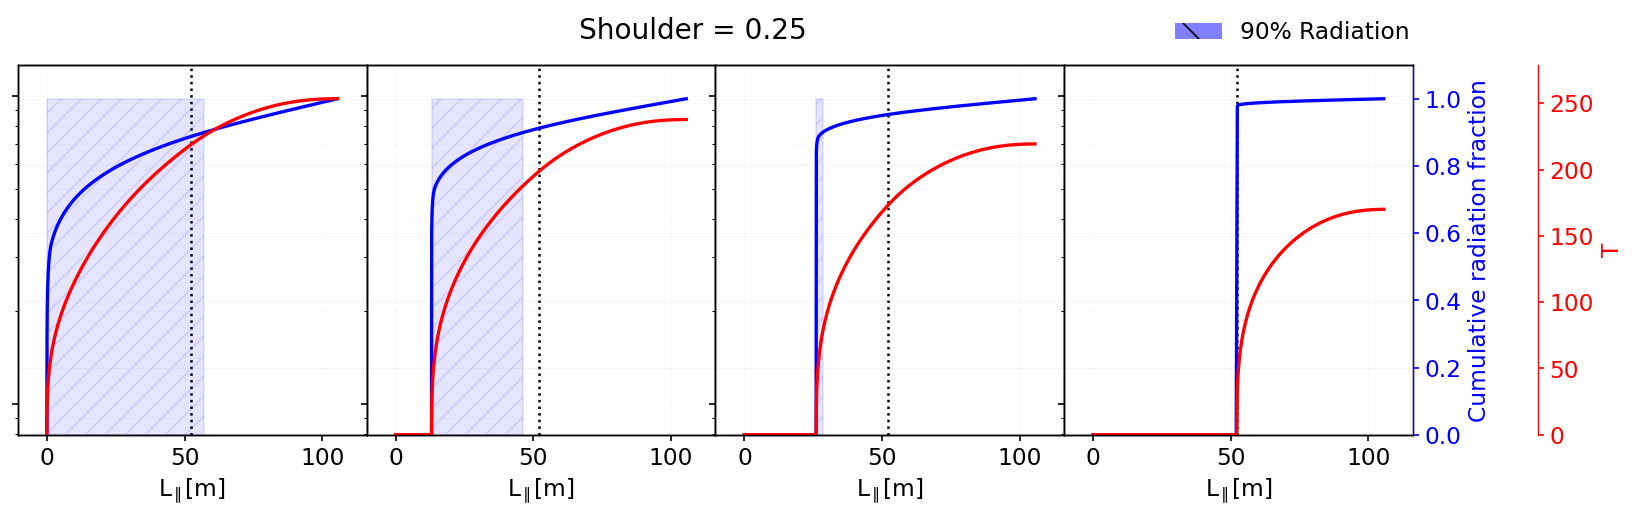

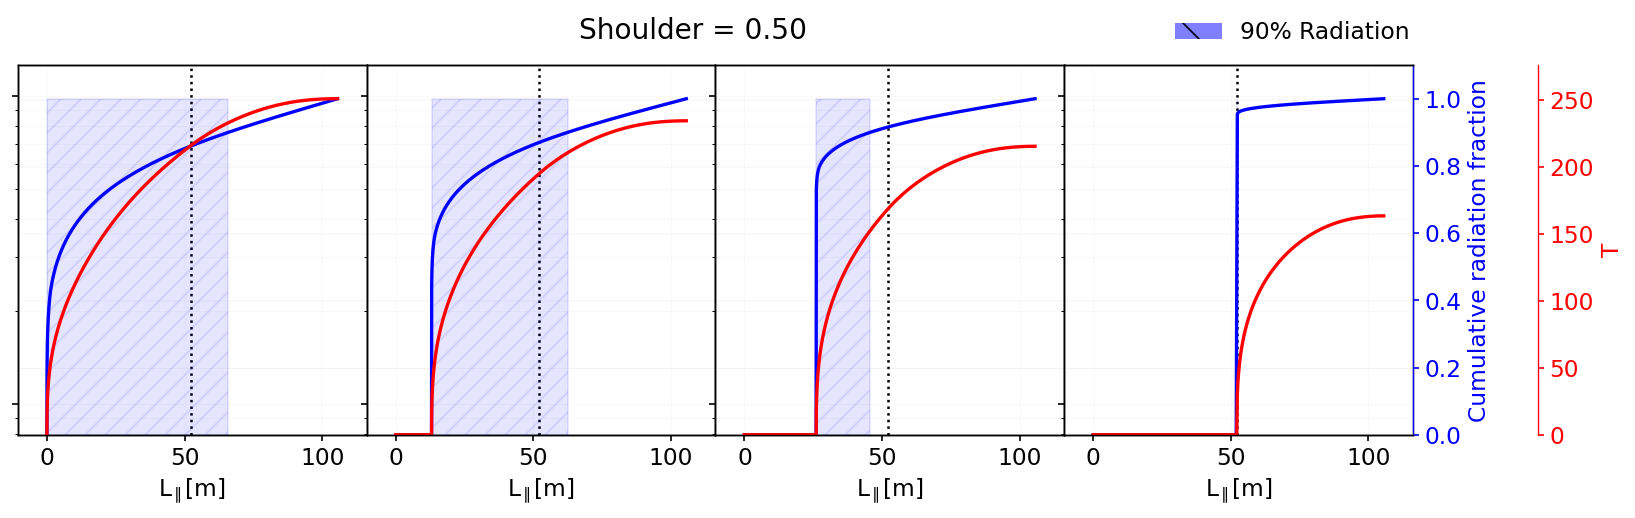

In [246]:
for Tmax in store_shoulder.keys():
    p = eqb["SPR45"]["ol"]
    s = store_shoulder[Tmax]
    plot_profile_histories(p, s, [0, 1, 2, 4], rad_threshold = 0.9, mode = "temp", title = f"Shoulder = {Tmax:.2f}")

## Kink

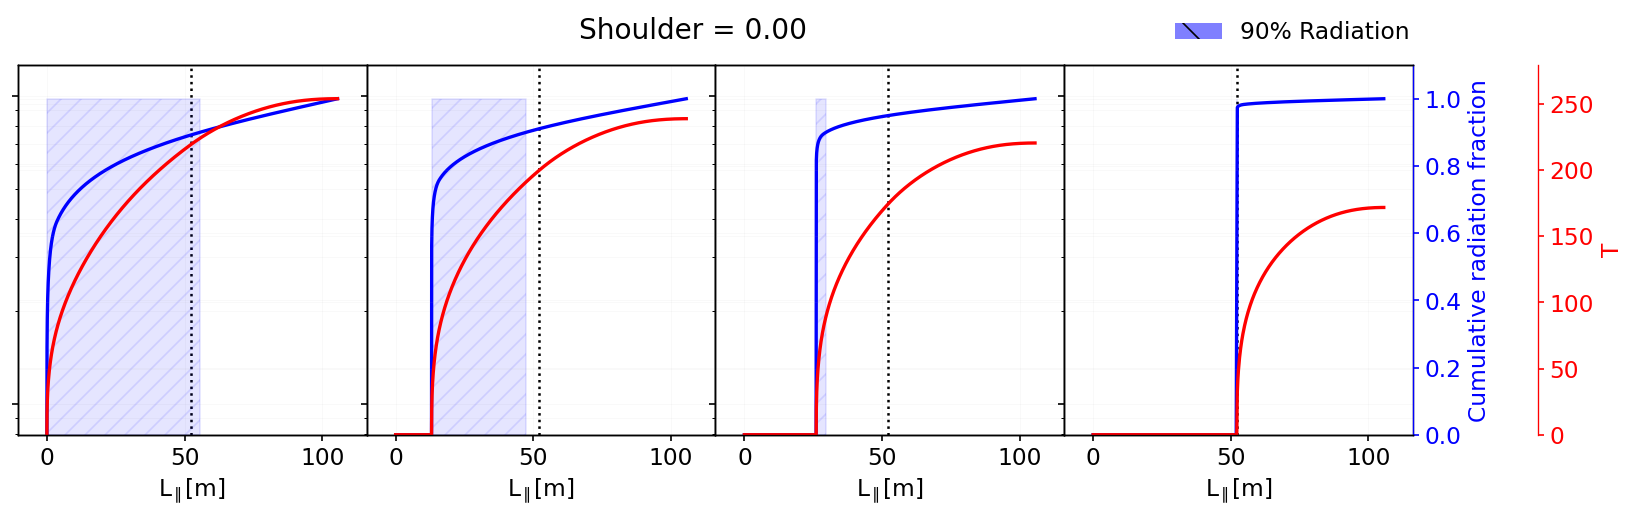

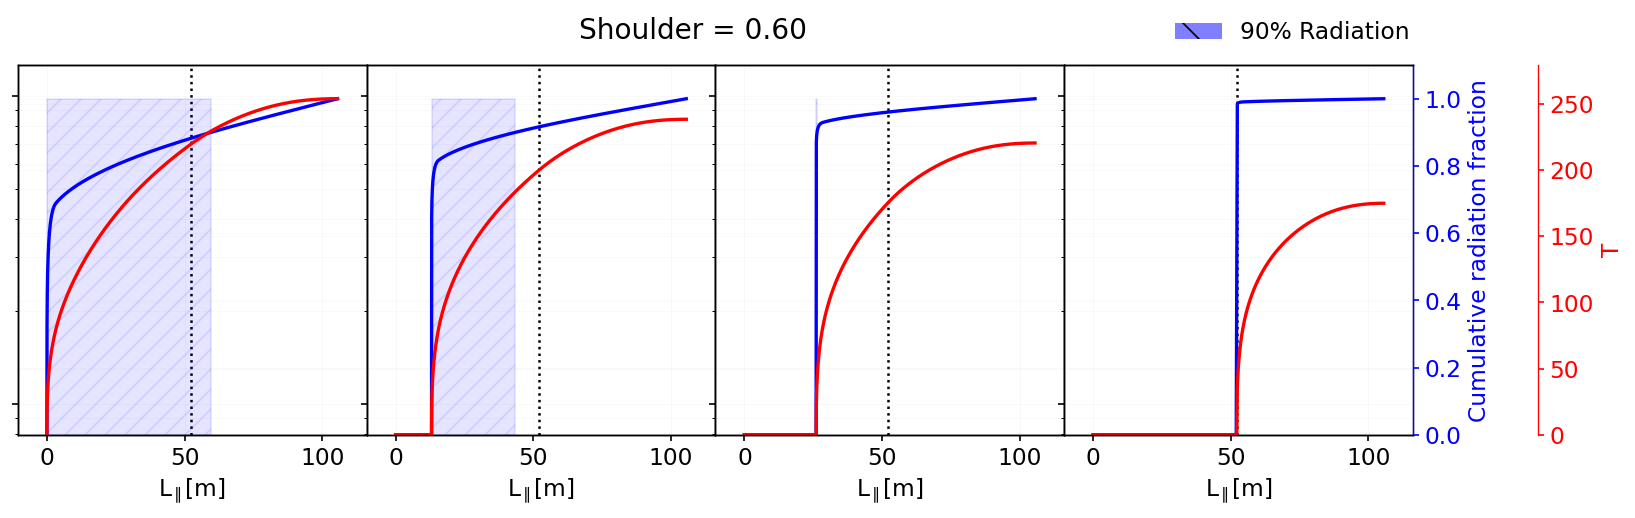

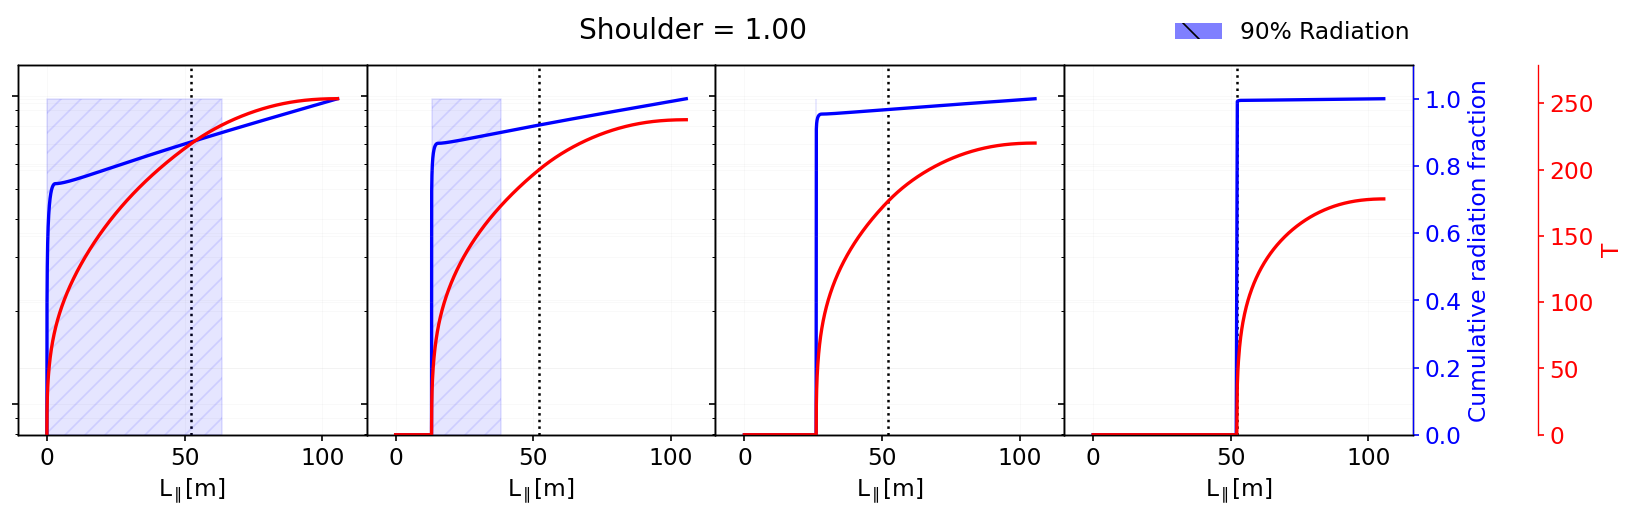

In [262]:
for Tmax in store_kink.keys():
    p = eqb["SPR45"]["ol"]
    s = store_kink[Tmax]
    plot_profile_histories(p, s, [0, 1, 2, 4], rad_threshold = 0.9, mode = "temp", title = f"Shoulder = {Tmax:.2f}")

# Postprocess front performance

## No shoulder

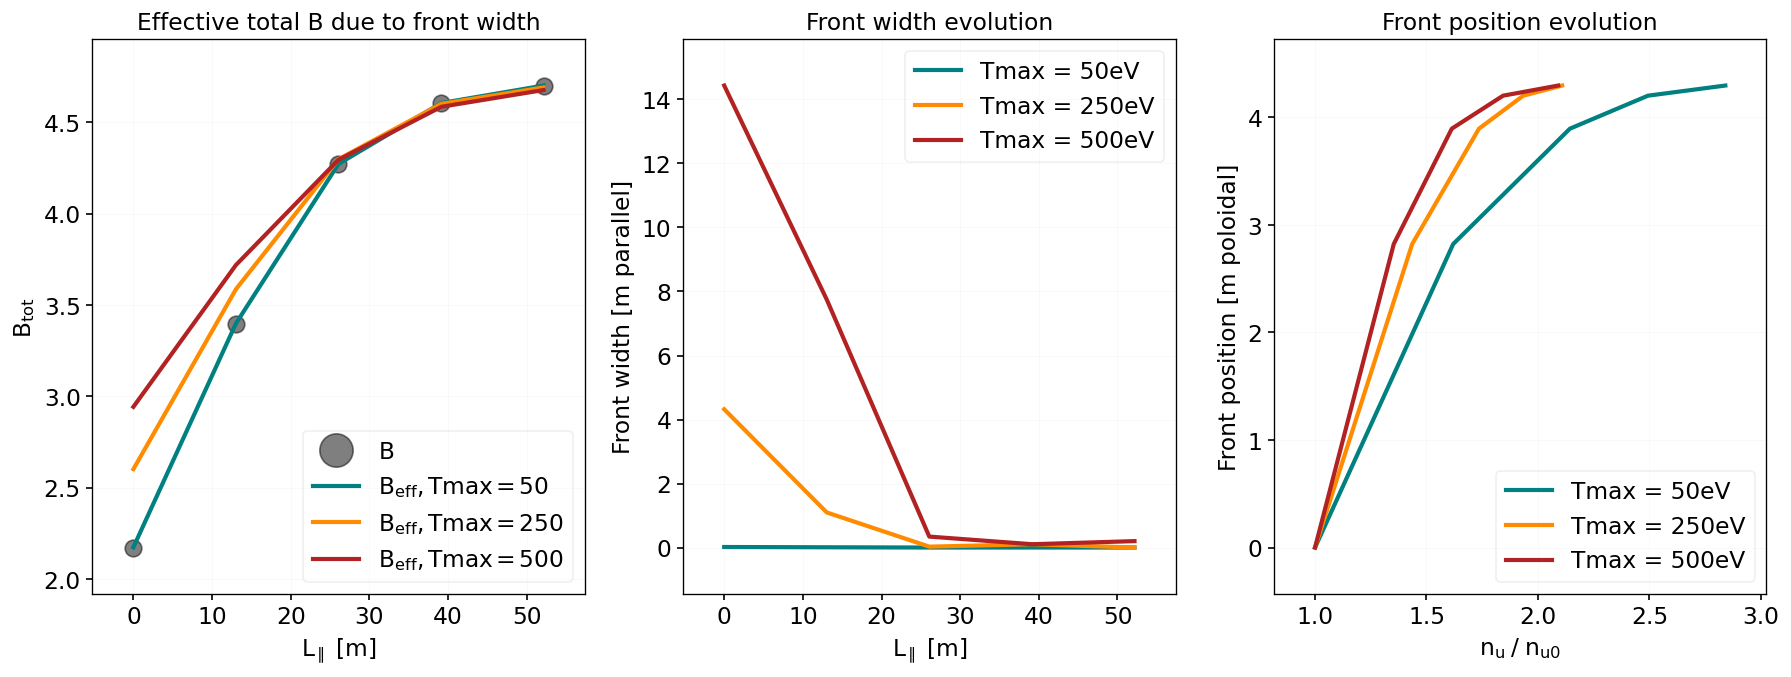

In [231]:
p = eqb["SPR45"]["ol"]


fig, axes = plt.subplots(1,3, figsize = (18,6))

axes[0].plot(df["Spar"], df["Btot"], label = "$B$", ms = 10, marker = "o", lw = 0, c = "k", alpha = 0.5)

for Tmax in store.keys():

    s = store[Tmax]
    df = get_front_widths(p = eqb["SPR45"]["ol"], s = s)

    R = s["Rprofiles"][0]
    B = p["Btot"]
    Rint = sp.integrate.trapezoid(y = R, x = p["S"])
    Beff = sp.integrate.trapezoid(y = R*B, x = p["S"]) / Rint

    axes[0].plot(df["Spar"], df["Btot_eff"], label = f"$B_{{eff}}, Tmax = {Tmax}$", lw = 2.5)
    axes[1].plot(df["Spar"], df["Spar_front_width"], label = f"Tmax = {Tmax}eV", lw = 2.5)
    axes[2].plot(df["crel"], df["Spol"], label = f"Tmax = {Tmax}eV", lw = 2.5)
    
    
axes[0].set_xlabel("$L_{\parallel}$ [m]")
axes[0].set_ylabel("$B_{tot}$")
axes[0].set_title("Effective total B due to front width")

axes[1].set_xlabel("$L_{\parallel}$ [m]")
axes[1].set_ylabel("Front width [m parallel]")
axes[1].set_title("Front width evolution")

axes[2].set_xlabel("$n_{u} \ /\  n_{u0}$")
axes[2].set_ylabel("Front position [m poloidal]")
axes[2].set_title("Front position evolution")

for ax in axes:
    ax.legend()
# ax.set_ylim(0,0.1e9)

## Shoulder

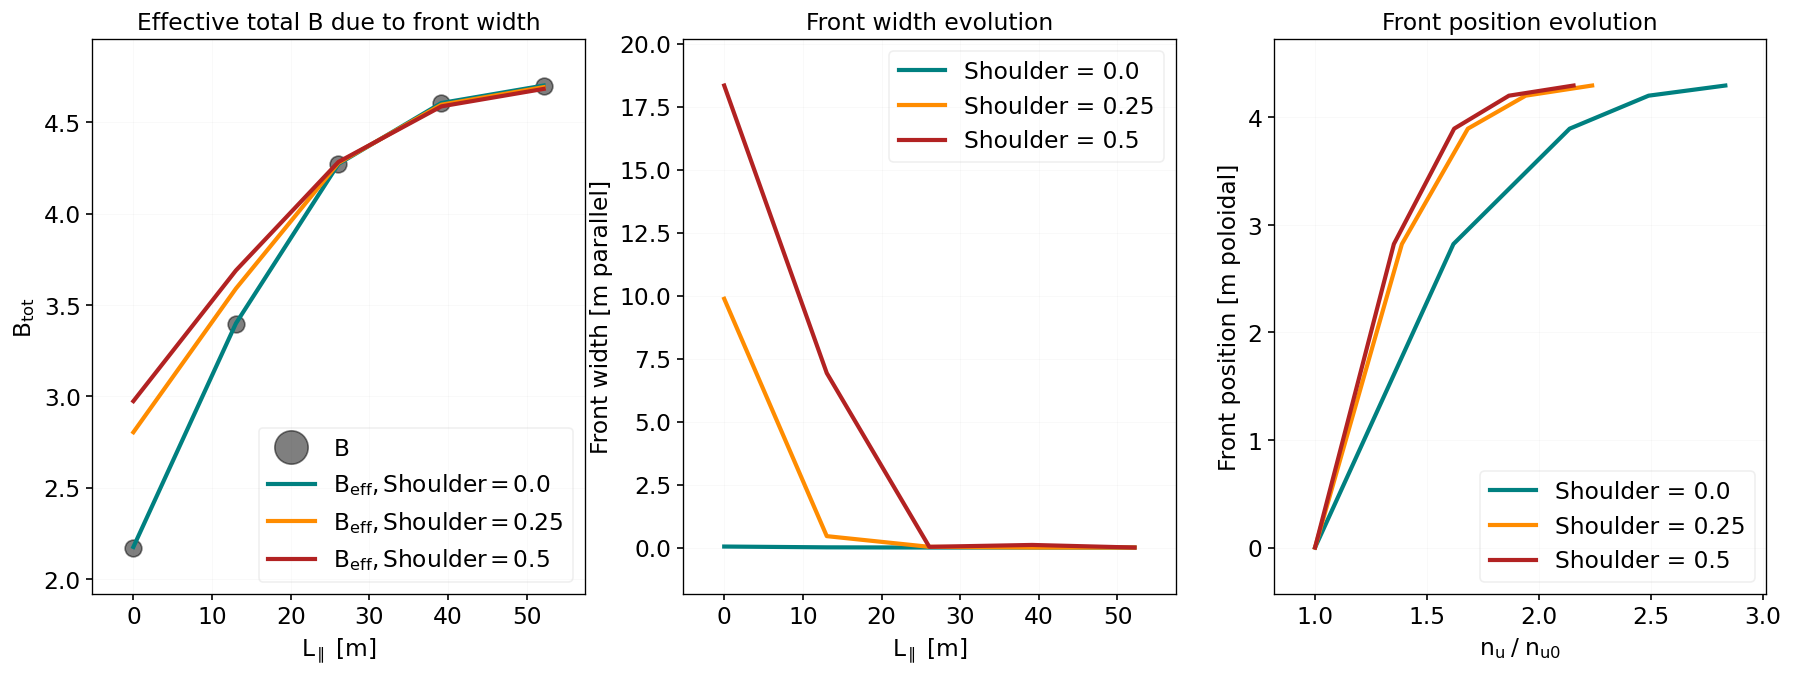

In [266]:
p = eqb["SPR45"]["ol"]
store = store_shoulder

fig, axes = plt.subplots(1,3, figsize = (18,6))

axes[0].plot(df["Spar"], df["Btot"], label = "$B$", ms = 10, marker = "o", lw = 0, c = "k", alpha = 0.5)

for shoulder in store.keys():

    s = store[shoulder]
    df = get_front_widths(p = eqb["SPR45"]["ol"], s = s)

    R = s["Rprofiles"][0]
    B = p["Btot"]
    Rint = sp.integrate.trapezoid(y = R, x = p["S"])
    Beff = sp.integrate.trapezoid(y = R*B, x = p["S"]) / Rint

    axes[0].plot(df["Spar"], df["Btot_eff"], label = f"$B_{{eff}}, Shoulder = {shoulder}$", lw = 2.5)
    axes[1].plot(df["Spar"], df["Spar_front_width"], label = f"Shoulder = {shoulder}", lw = 2.5)
    axes[2].plot(df["crel"], df["Spol"], label = f"Shoulder = {shoulder}", lw = 2.5)
    
    
axes[0].set_xlabel("$L_{\parallel}$ [m]")
axes[0].set_ylabel("$B_{tot}$")
axes[0].set_title("Effective total B due to front width")

axes[1].set_xlabel("$L_{\parallel}$ [m]")
axes[1].set_ylabel("Front width [m parallel]")
axes[1].set_title("Front width evolution")

axes[2].set_xlabel("$n_{u} \ /\  n_{u0}$")
axes[2].set_ylabel("Front position [m poloidal]")
axes[2].set_title("Front position evolution")

for ax in axes:
    ax.legend()
# ax.set_ylim(0,0.1e9)

## Kink

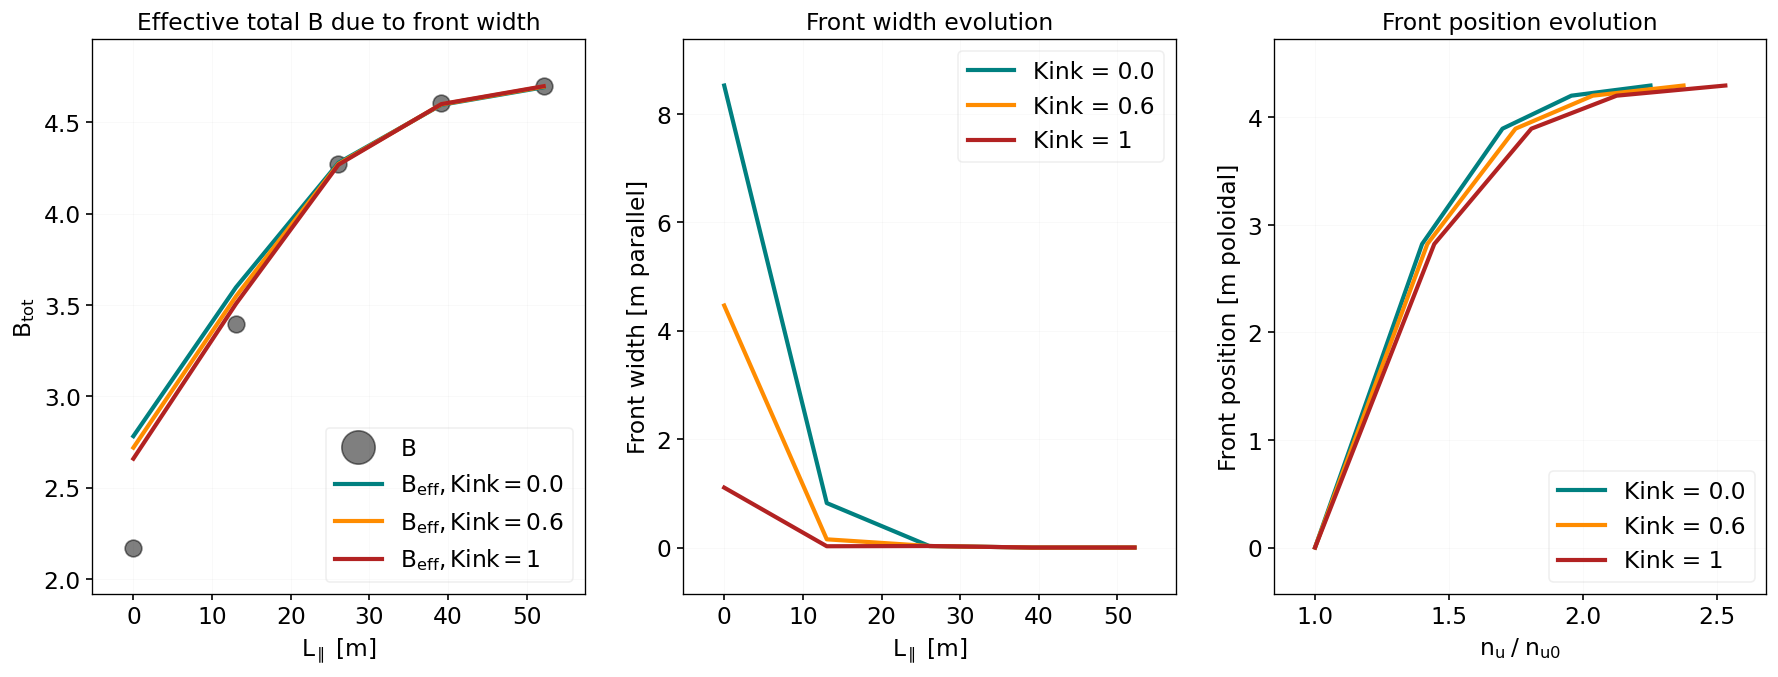

In [264]:
p = eqb["SPR45"]["ol"]
store = store_kink

fig, axes = plt.subplots(1,3, figsize = (18,6))

axes[0].plot(df["Spar"], df["Btot"], label = "$B$", ms = 10, marker = "o", lw = 0, c = "k", alpha = 0.5)

for kink in store.keys():

    s = store[kink]
    df = get_front_widths(p = eqb["SPR45"]["ol"], s = s)

    R = s["Rprofiles"][0]
    B = p["Btot"]
    Rint = sp.integrate.trapezoid(y = R, x = p["S"])
    Beff = sp.integrate.trapezoid(y = R*B, x = p["S"]) / Rint

    axes[0].plot(df["Spar"], df["Btot_eff"], label = f"$B_{{eff}}, Kink = {kink}$", lw = 2.5)
    axes[1].plot(df["Spar"], df["Spar_front_width"], label = f"Kink = {kink}", lw = 2.5)
    axes[2].plot(df["crel"], df["Spol"], label = f"Kink = {kink}", lw = 2.5)
    
    
axes[0].set_xlabel("$L_{\parallel}$ [m]")
axes[0].set_ylabel("$B_{tot}$")
axes[0].set_title("Effective total B due to front width")

axes[1].set_xlabel("$L_{\parallel}$ [m]")
axes[1].set_ylabel("Front width [m parallel]")
axes[1].set_title("Front width evolution")

axes[2].set_xlabel("$n_{u} \ /\  n_{u0}$")
axes[2].set_ylabel("Front position [m poloidal]")
axes[2].set_title("Front position evolution")

for ax in axes:
    ax.legend()
# ax.set_ylim(0,0.1e9)

## Impurity

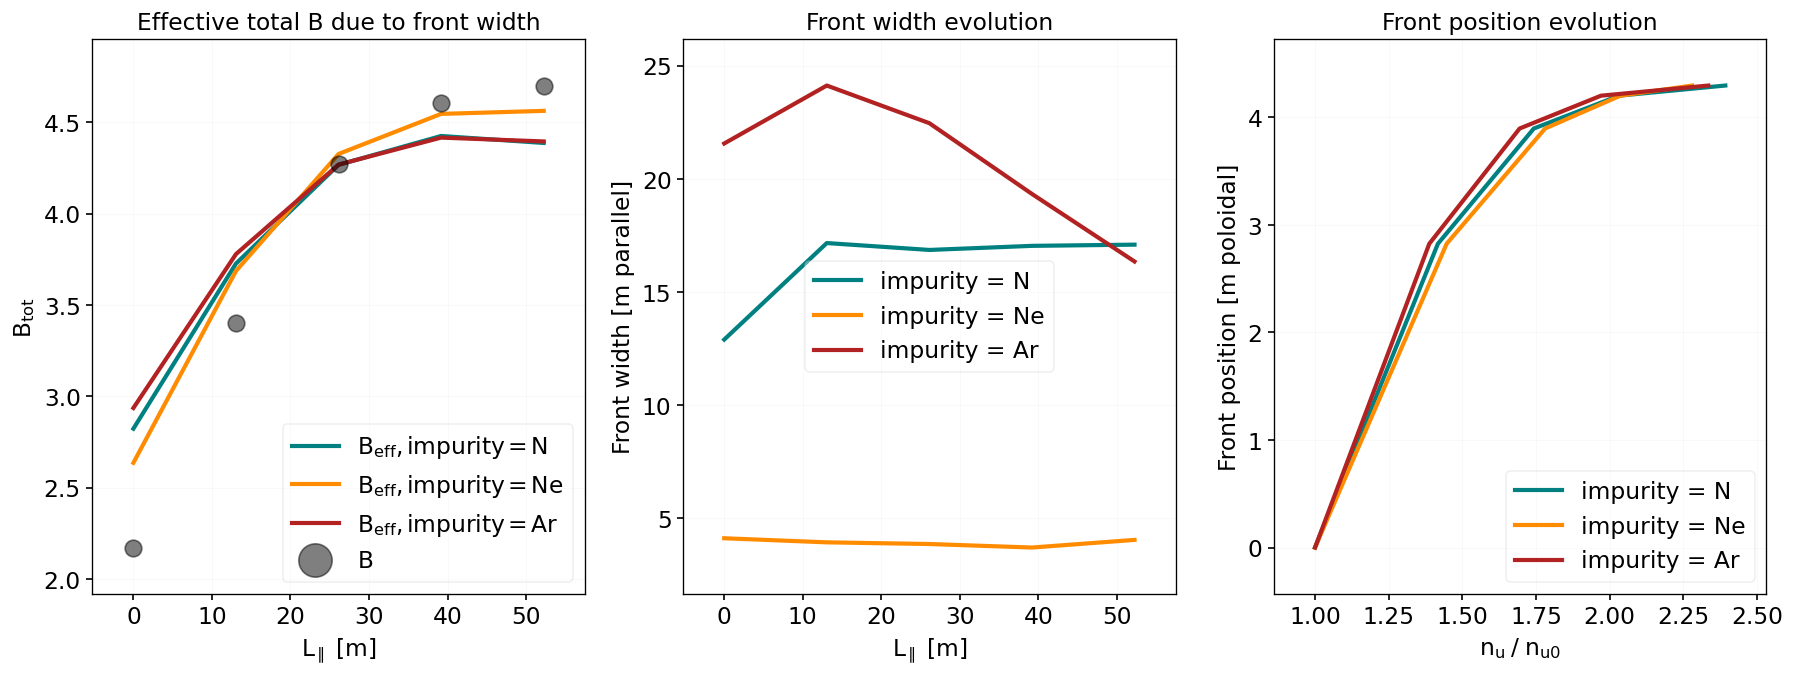

In [209]:
p = eqb["SPR45"][100000]["ol"]
store = store_impurity

fig, axes = plt.subplots(1,3, figsize = (18,6))



for impurity in store.keys():

    s = store[impurity]
    df = get_front_widths(p = p, s = s, Rcutoff = 0.05)

    R = s["Rprofiles"][0]
    B = p["Btot"]
    Rint = sp.integrate.trapezoid(y = R, x = p["S"])
    Beff = sp.integrate.trapezoid(y = R*B, x = p["S"]) / Rint

    axes[0].plot(df["Spar"], df["Btot_eff"], label = f"$B_{{eff}}, impurity = {impurity}$", lw = 2.5)
    axes[1].plot(df["Spar"], df["Spar_front_width"], label = f"impurity = {impurity}", lw = 2.5)
    axes[2].plot(df["crel"], df["Spol"], label = f"impurity = {impurity}", lw = 2.5)
    
axes[0].plot(df["Spar"], df["Btot"], label = "$B$", ms = 10, marker = "o", lw = 0, c = "k", alpha = 0.5)
    
axes[0].set_xlabel("$L_{\parallel}$ [m]")
axes[0].set_ylabel("$B_{tot}$")
axes[0].set_title("Effective total B due to front width")

axes[1].set_xlabel("$L_{\parallel}$ [m]")
axes[1].set_ylabel("Front width [m parallel]")
axes[1].set_title("Front width evolution")

axes[2].set_xlabel("$n_{u} \ /\  n_{u0}$")
axes[2].set_ylabel("Front position [m poloidal]")
axes[2].set_title("Front position evolution")

for ax in axes:
    ax.legend()
# ax.set_ylim(0,0.1e9)

## Peak location

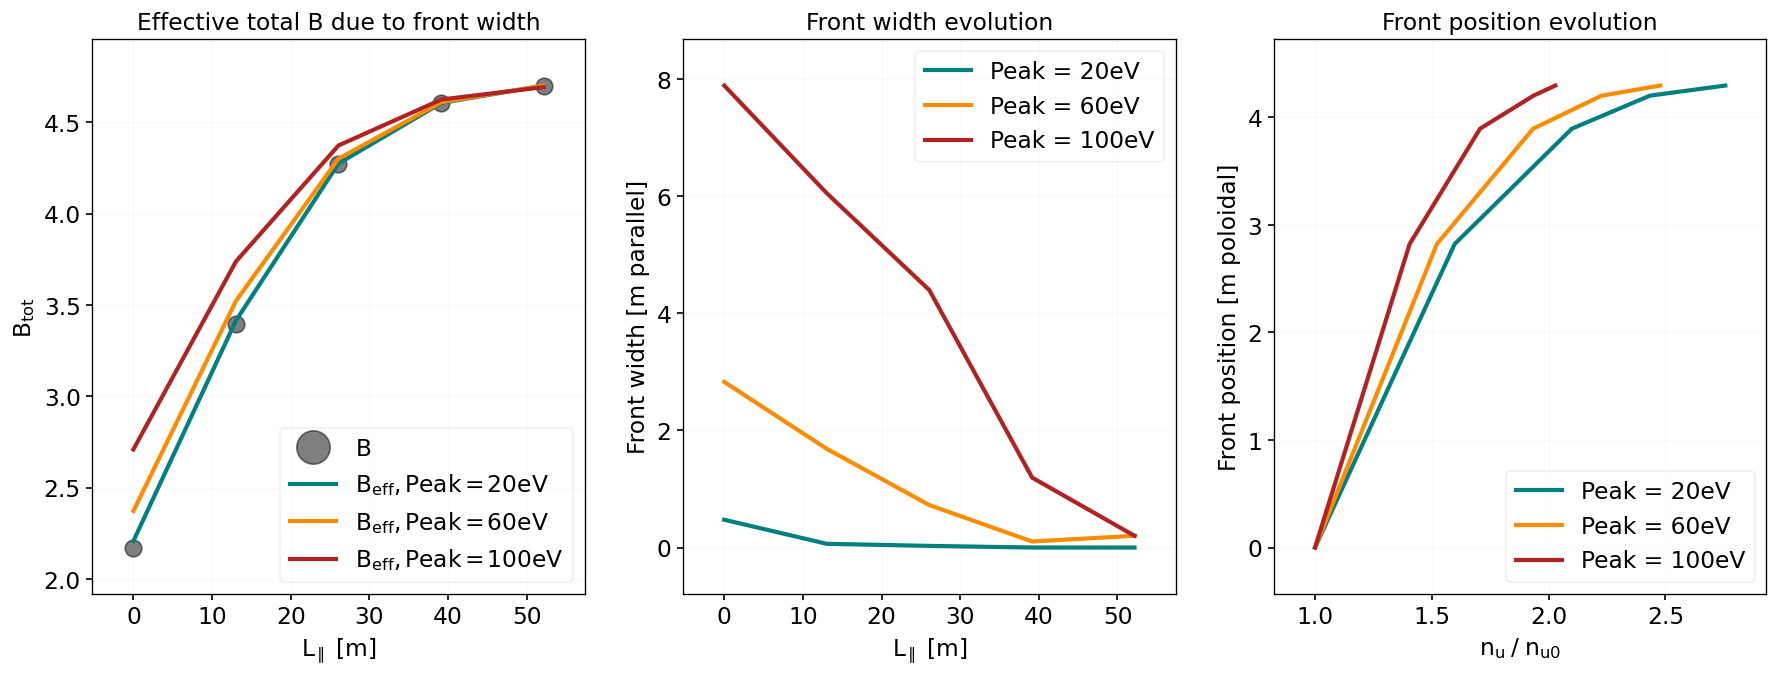

In [304]:
p = eqb["SPR45"]["ol"]
store = store_peakloc

fig, axes = plt.subplots(1,3, figsize = (18,6))

axes[0].plot(df["Spar"], df["Btot"], label = "$B$", ms = 10, marker = "o", lw = 0, c = "k", alpha = 0.5)

for peak in store.keys():

    s = store[peak]
    df = get_front_widths(p = eqb["SPR45"]["ol"], s = s)

    R = s["Rprofiles"][0]
    B = p["Btot"]
    Rint = sp.integrate.trapezoid(y = R, x = p["S"])
    Beff = sp.integrate.trapezoid(y = R*B, x = p["S"]) / Rint

    axes[0].plot(df["Spar"], df["Btot_eff"], label = f"$B_{{eff}}, Peak = {peak}eV$", lw = 2.5)
    axes[1].plot(df["Spar"], df["Spar_front_width"], label = f"Peak = {peak}eV", lw = 2.5)
    axes[2].plot(df["crel"], df["Spol"], label = f"Peak = {peak}eV", lw = 2.5)
    
    
axes[0].set_xlabel("$L_{\parallel}$ [m]")
axes[0].set_ylabel("$B_{tot}$")
axes[0].set_title("Effective total B due to front width")

axes[1].set_xlabel("$L_{\parallel}$ [m]")
axes[1].set_ylabel("Front width [m parallel]")
axes[1].set_title("Front width evolution")

axes[2].set_xlabel("$n_{u} \ /\  n_{u0}$")
axes[2].set_ylabel("Front position [m poloidal]")
axes[2].set_title("Front position evolution")

for ax in axes:
    ax.legend()
# ax.set_ylim(0,0.1e9)

In [50]:
%matplotlib widget

Text(0.5, 0, '$L_{\\parallel}$ [m]')

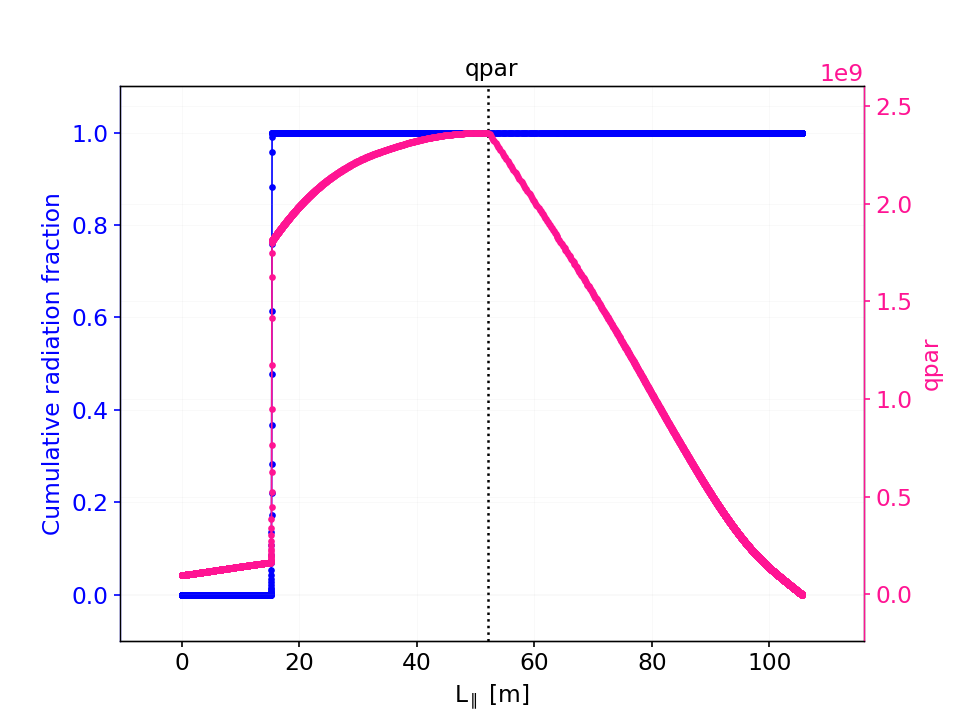

In [87]:
plt.close("all")

p = eqb["SPR45"]["ol"]
s = store[0.005]


idx = 0
x = p["S"]
R = s["Rprofiles"][idx]
R = pad_profile(x, R)
T = pad_profile(x, s["Tprofiles"][idx])

Rcum = sp.integrate.cumulative_trapezoid(y = R, x = x, initial = 0)
Rcum /= Rcum.max()

fig, ax1 = plt.subplots()

ax1.axvline(x = x[p["Xpoint"]], c = "k", ls = ":", lw = 1.5)
ax1color = "blue"
ax1.plot(x, Rcum, color = "blue", ls = "-", label = "Cumulative radiation integral", lw = 1,   alpha = 1, marker = "o", ms = 3)
ax1.spines["left"].set_color(ax1color)
ax1.tick_params(axis = "y", colors = ax1color)
ax1.yaxis.label.set_color(color = ax1color)
ax1.set_ylabel("Cumulative radiation fraction")

ax2 =  ax1.twinx()

ax2color = "deeppink"
ax2.plot(x, pad_profile(x, s["Qprofiles"][idx]), c = ax2color, lw = 1, label = r"$R$", alpha = 1, marker = "o", ms = 3)
ax2.set_ylabel("qpar")
ax2.set_title("qpar")

# ax2color = "darkorange"
# ax2.plot(x, pad_profile(x, s["Rprofiles"][idx]), c = ax2color, lw = 1, label = r"$R$", alpha = 1, marker = "o", ms = 3)
# ax2.set_ylabel("radiation")
# ax2.set_yscale("log")
# ax2.set_title("Radiation")

# ax2color = "red"
# ax2.plot(x, pad_profile(x, s["Tprofiles"][idx]), c = ax2color, lw = 1, label = r"$R$", alpha = 1, marker = "o", ms = 3)
# ax2.set_ylabel("temp")
# ax2.set_title("Temp")


ax2.spines["right"].set_color(ax2color)
ax2.tick_params(axis = "y", colors = ax2color)
ax2.yaxis.label.set_color(color = ax2color)

ax1.set_xlabel(r"$L_{\parallel}$ [m]")
# ax1.set_xlim(25,60)
# ax1.set_yscale("log")
# ax1.set_ylim(1e-6, 1)
# ax.set_yscale("log")

In [ ]:
# Which part of the coo

# Comparison of shrinking vs. expanding front

## Compare gradients

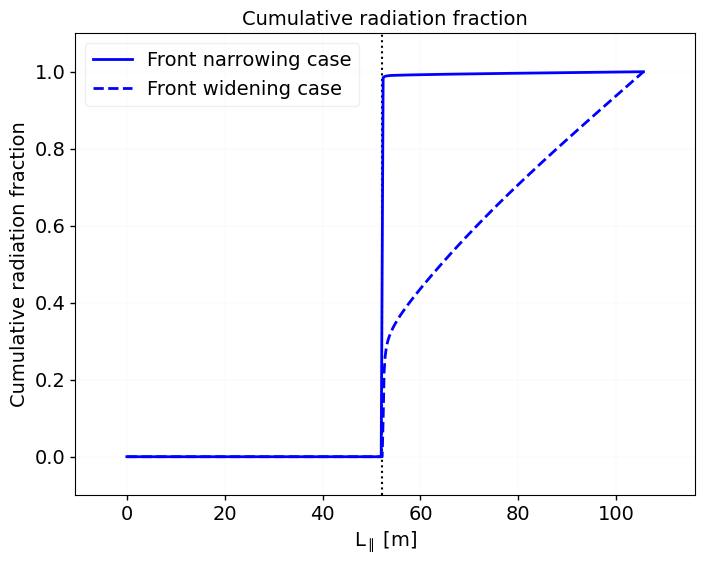

In [93]:
plt.close("all")

p = eqb["SPR45"]["ol"]
x = p["S"]


fig, ax = plt.subplots(dpi = 100)

ax.axvline(x = x[p["Xpoint"]], c = "k", ls = ":", lw = 1.5)

markers = ["o", "x"]
labels = ["Front narrowing case", "Front widening case"]
linestyles = ["-", "--"]
Lfuncs = [lambda x: LfuncArParametricTriShoulderKink(x, 0.6), LfuncKallenbachAr]
idx = 4
for i, s in enumerate([store_kink[0.6], store_impurity["Ar"]]):
    R = s["Rprofiles"][idx]
    R = pad_profile(x, R)
    T = pad_profile(x, s["Tprofiles"][idx])

    Rcum = sp.integrate.cumulative_trapezoid(y = R, x = x, initial = 0)
    Rcum /= Rcum.max()
    
    
    # ax.plot(x, pad_profile(x, T), c = "red", lw = 2, alpha = 1, marker = markers[i], ms = 0, label = labels[i], ls = linestyles[i])
    # ax.set_ylabel("temp")
    # ax.set_title("temp")
    
    # for idx in [4]:
    #     T = pad_profile(x, s["Tprofiles"][idx])
    #     Lz = [Lfuncs[i](x) for x in T]
    #     ax.plot(x, Lz, c = "teal", lw = 2, alpha = 1, marker = markers[i], ms = 0, label = labels[i] if idx == 4 else None, ls = linestyles[i])
    
    ax.plot(x, Rcum, color = "blue", lw = 2,   alpha = 1, marker = markers[i], ms = 0, label = labels[i], ls = linestyles[i])
    ax.set_ylabel("Cumulative radiation fraction")
    ax.set_title("Cumulative radiation fraction")
    
    # ax.plot(s["Tprofiles"][idx], s["Rprofiles"][idx], c = "deeppink", lw = 1, alpha = 1, marker = markers[i], ms = 3, label = labels[i])



ax.set_xlabel(r"$L_{\parallel}$ [m]")
# ax.set_xlim(12,60)
# ax.set_xlim(12,18)
# ax.set_xlim(50,56)
ax.legend()
# ax1.set_yscale("log")
# ax1.set_ylim(1e-6, 1)
# ax.set_yscale("log")

## Compare which curve regions are utilised

In [109]:
store_peakloc.keys()

dict_keys([20, 60, 100])

In [192]:
eqb["SPR45"][100000]["ol"]["S"].shape

(100000,)

In [191]:
store_impurity["Ar"]["Tprofiles"][1].shape

(75220,)

In [198]:
pad_profile(L, s["Tprofiles"][idx]).shape

(100000,)

Text(0.5, 1.0, 'argon curve, Lpar = 0.00m')

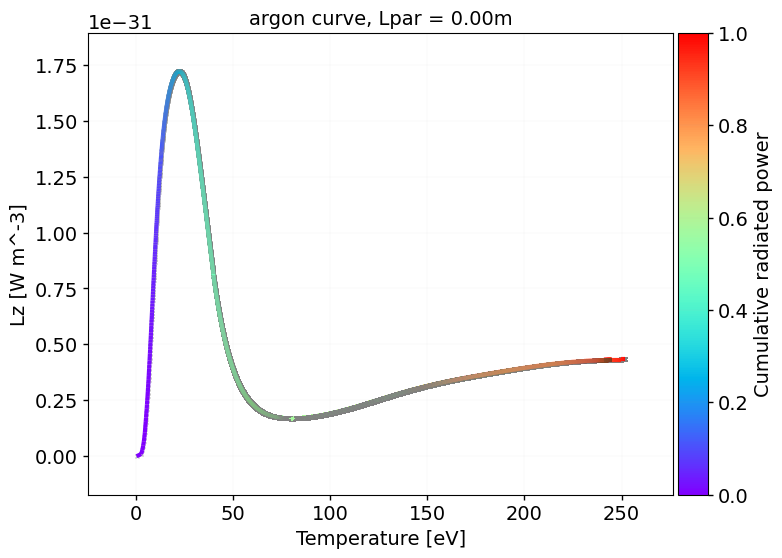

In [202]:
fig, ax = plt.subplots(dpi = 100)

cases = dict(
    kink = {"store" : store_kink[0.6], "lfunc" : lambda x: LfuncArParametricTriShoulderKink(x, 0.6)},
    peakloc = {"store" : store_peakloc[100], "lfunc" : lambda x: LfuncArParametricTriPeakLoc(x, 100)},
    argon = {"store" : store_impurity["Ar"], "lfunc" : LfuncKallenbachAr}
)

casename = "argon"
case = cases[casename]

idx = 0
s = case["store"]
p = eqb["SPR45"][100000]["ol"]
L = p["S"]
R = s["Rprofiles"][idx]
R = pad_profile(L, R)
Rcum = sp.integrate.cumulative_trapezoid(y = R, x = L, initial = 0)
Rcum /= Rcum.max()
T = pad_profile(L, s["Tprofiles"][idx])

x = T
y = [case["lfunc"](x) for x in T]
c = Rcum

ax.plot(x,y, marker = "x", markerfacecolor ="k", c = "grey", alpha= 0.5, lw = 0, ms = 3)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

cmap = "rainbow"
norm = mpl.colors.Normalize(vmin = min(c), vmax = max(c))
# norm = mpl.colors.SymLogNorm(vmin = 1e7, vmax = max(c),linthresh = 1)
lc = LineCollection(segments, cmap = cmap, norm = norm, zorder = 100)
lc.set_array(c)
lc.set_linewidth(3)
line = ax.add_collection(lc)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), cax = cax, 
                format = mpl.ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x)), 
                )
cbar.set_label("Cumulative radiated power")

ax.set_xlabel("Temperature [eV]")
ax.set_ylabel("Lz [W m^-3]")
ax.set_title(f"{casename} curve, Lpar = {s['Splot'][idx]:.2f}m")

In [ ]:
plt.close("all")

p = eqb["SPR45"]["ol"]
s = store[0.005]


idx = 0
x = p["S"]
R = s["Rprofiles"][idx]
R = pad_profile(x, R)
T = pad_profile(x, s["Tprofiles"][idx])

Rcum = sp.integrate.cumulative_trapezoid(y = R, x = x, initial = 0)
Rcum /= Rcum.max()

fig, ax1 = plt.subplots()

ax1.axvline(x = x[p["Xpoint"]], c = "k", ls = ":", lw = 1.5)
ax1color = "blue"
ax1.plot(x, Rcum, color = "blue", ls = "-", label = "Cumulative radiation integral", lw = 1,   alpha = 1, marker = "o", ms = 3)
ax1.spines["left"].set_color(ax1color)
ax1.tick_params(axis = "y", colors = ax1color)
ax1.yaxis.label.set_color(color = ax1color)
ax1.set_ylabel("Cumulative radiation fraction")

ax2 =  ax1.twinx()

ax2color = "deeppink"
ax2.plot(x, pad_profile(x, s["Qprofiles"][idx]), c = ax2color, lw = 1, label = r"$R$", alpha = 1, marker = "o", ms = 3)
ax2.set_ylabel("qpar")
ax2.set_title("qpar")

# ax2color = "darkorange"
# ax2.plot(x, pad_profile(x, s["Rprofiles"][idx]), c = ax2color, lw = 1, label = r"$R$", alpha = 1, marker = "o", ms = 3)
# ax2.set_ylabel("radiation")
# ax2.set_yscale("log")
# ax2.set_title("Radiation")

# ax2color = "red"
# ax2.plot(x, pad_profile(x, s["Tprofiles"][idx]), c = ax2color, lw = 1, label = r"$R$", alpha = 1, marker = "o", ms = 3)
# ax2.set_ylabel("temp")
# ax2.set_title("Temp")


ax2.spines["right"].set_color(ax2color)
ax2.tick_params(axis = "y", colors = ax2color)
ax2.yaxis.label.set_color(color = ax2color)

ax1.set_xlabel(r"$L_{\parallel}$ [m]")
# ax1.set_xlim(25,60)
# ax1.set_yscale("log")
# ax1.set_ylim(1e-6, 1)
# ax.set_yscale("log")